In [1]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import csv
import math
import matplotlib.pyplot
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [2]:
# get data from .csv file and parse them 
#filename = filename.csv
def get_data(filename):
    with open(filename, 'r') as f:
        dat = csv.reader(f, delimiter = ',')
        #get column name from first row
        col_name = next(dat)
        #get all the rows as a list
        data = list(dat)
        #return data as numpy array
    return np.array(data)


#Processing Dataset # concatenation of paired up img_ids
# args: data: humanobserved-features , # pair: list of same or diff pairs. 
def process_data(data, pair, x):
    
    features = []
    target = []
    for i in range(len(pair)):
        for j in range(len(data)):
            if pair[i][x] == data[j][0]:
                f = (data[j][1:]) 
                features.append(f)
    return features

# get target vector
def getTarget(pair):
    return  np.array([pair[t][-1] for t in range(len(pair))]).astype(float)

In [3]:
#get data form the csv file 
data = get_data('HumanObserved-Features-Data.csv')

dat = np.array([data[d][1:] for d in range(len(data))])
d_pair = get_data('diffn_pairs.csv')

#take only 791 diff pairs to balance the dataset
diff_pair = d_pair[:791]
same_pair = get_data('same_pairs.csv')

print(dat.shape)
print(diff_pair.shape)
print(same_pair.shape)
# print(same_pair[:3])
# print(diff_pair[:3])
# print(data[1][1:])

(1026, 10)
(791, 3)
(791, 3)


# concatenate same data pair

In [4]:
def getData(data, pair, operation):
    img1 = np.array(process_data(data, pair, x = 0)).astype(float)
    img2 = np.array(process_data(data, pair, x = 1)).astype(float)
    if operation == 'concatenate':
        feature = np.array(np.concatenate((img1, img2), axis = 1))
        
    elif operation =='subtract':
        feature = np.abs(np.array(img1 - img2))
        
    return feature

In [5]:
# get target
Target_same = getTarget(same_pair)
Target_diff = getTarget(diff_pair)
print(Target_same.shape)
print(Target_diff.shape)

(791,)
(791,)


In [6]:
# get concatenate and subtrated features for same and different pairs
same_sub = getData(dat, same_pair, operation = 'subtract')
same_conc = getData(dat, same_pair, operation = 'concatenate')
diff_sub = getData(dat, diff_pair, operation = 'subtract')
diff_conc = getData(dat, diff_pair, operation = 'concatenate')
print(same_sub.shape)
print(same_conc.shape)
print(diff_conc.shape)
print(diff_sub.shape)

(791, 9)
(791, 18)
(791, 18)
(791, 9)


## add target column on concatenated and subtracted matrix of same and diff pairs

In [7]:
# add target to concatenated feature dataset
same_conc_t = np.c_[same_conc, Target_same]
diff_conc_t = np.c_[diff_conc, Target_diff]

#diff_conc_t = np.array(diff_conc_t[:791])
print(same_conc_t.shape)
print(diff_conc_t.shape)


# add target to subtracted feature dataset
same_sub_t = np.c_[same_sub, Target_same]
diff_sub_t = np.c_[diff_sub, Target_diff]
#diff_sub_t = np.array(diff_sub_t[:791])
print(same_sub_t.shape)
print(diff_sub_t.shape)


(791, 19)
(791, 19)
(791, 10)
(791, 10)


# Concatenate same and different pairs and randomly shuffle 

In [8]:
#1. human observed feature concatenated # concatenate same and diff pairs matrices and shuffle them
h_obs_conc = np.concatenate((same_conc_t, diff_conc_t), axis = 0)

np.random.shuffle(h_obs_conc)  # randomly shuffle same and diff pairs

#2.human observed features subtracted # concatenate same and diff pairs and shuffle them
h_obs_sub = np.concatenate((same_sub_t,diff_sub_t ), axis = 0)

np.random.shuffle(h_obs_sub)

print(h_obs_conc.shape)
print(h_obs_sub.shape)
#print(h_obs_conc[:5]) # print first five rows of the parsed data
#print(h_obs_sub[:5])


(1582, 19)
(1582, 10)


In [9]:
#get target for concatenated dataset

Target_conc = h_obs_conc[:, -1]
print(Target_conc.shape)

#get target for subtrated dataset
Target_sub = h_obs_sub[:, -1]
print(Target_sub.shape)


#get concatenated matrix after shuffling diff and same pairs

feature_conc = h_obs_conc[:,:-1]  
print(feature_conc.shape)
##get data : human observed features concatenated (18 features)
feature_sub = h_obs_sub[:, :-1]  
print(feature_sub.shape)
# DataMatrix = np.array([h_obs_con[t][:-1] for t in range(len(h_obs_con))]).astype(float)
# print(DataMatrix.shape)


(1582,)
(1582,)
(1582, 18)
(1582, 9)


# Model 1: Linear Regression

In [10]:
TrainingPercent = 80  # 80% of sample input will be assigned as training data set
ValidationPercent = 10 # 10% for validation
TestPercent = 10 

# 80% o/p target vector assigned as training 
def GenerateTrainingTarget(rawTraining,TrainingPercent = 80):
    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01)))
    t           = rawTraining[:TrainingLen]
    #print(str(TrainingPercent) + "% Training Target Generated..")
    return t

#80 of the data matrix assigned as training
def GenerateTrainingDataMatrix(rawData, TrainingPercent = 80):
    T_len = int(math.ceil(len(rawData)*(TrainingPercent*0.01)))
    d2 = rawData[:T_len]
    #print(str(TrainingPercent) + "% Training Data Generated..")
    return d2

#10% of dataset assigned a validation
def GenerateValData(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData)*ValPercent*0.01))
    V_End = TrainingCount + valSize
    dataMatrix = rawData[TrainingCount+1 : V_End]
    #print (str(ValPercent) + "% Val Data Generated..")  
    return dataMatrix


#10% of target vector for validation
def GenerateValTargetVector(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData)*ValPercent*0.01))
    V_End = TrainingCount + valSize
    t =rawData[TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Target Data Generated..")
    return t

def OutputValue_Lin(PhiMatrix, W_New):
    Op = np.dot(PhiMatrix, W_New)
    ##print ("Test Out Generated..")
    return Op

# get variance of the training data and generate a diagonal matrix of variances also called big sigma. 
#generate a 41x41 diagonal matrix with all other elements as zero.
def GenerateBigSigma(Data, MuMatrix,TrainingPercent,IsSynthetic):
    BigSigma    = np.zeros((len(Data),len(Data)))  # creating a dummy zero squares matrix m X m
    DataT       = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01)) # length of the training data 80% of DataT 
    varVect     = []
    for i in range(0,len(DataT[0])):
        vct = []
        for j in range(0,int(TrainingLen)):
            vct.append(Data[i][j])    
        varVect.append(np.var(vct))  # np.var : compute variance 
    
    for j in range(len(Data)):
        BigSigma[j][j] = varVect[j]  # diagonal elements of bigsigma : variance 
    if IsSynthetic == True:
        BigSigma = np.dot(3,BigSigma)
    else:
        # not necessary
        BigSigma = np.dot(200,BigSigma)   # scaling the variance by multiplying it by 200
    ##print ("BigSigma Generated..")
    return BigSigma


#computing the exponential term of the Gaussian basis function matrices and return a scalar value
def GetScalar(DataRow,MuRow, BigSigInv):  
    R = np.subtract(DataRow,MuRow)
    T = np.dot(BigSigInv,np.transpose(R))  
    L = np.dot(R,T)
    return L

#computing Gaussian Radial basis function.
def GetRadialBasisOut(DataRow,MuRow, BigSigInv):    
    phi_x = math.exp(-0.5*GetScalar(DataRow,MuRow,BigSigInv))
    return phi_x

#generating design matrix
def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 90):
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))         
    #generate a matriz placeholder 
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    BigSigInv = np.linalg.inv(BigSigma)
    
    # iterate : for each mu(anchor point), iterate over the row data points
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)): # 
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
    #print ("PHI Generated..")
    return PHI

#get Erms for linear regression
def Erms(VAL_TEST_OUT,ValDataAct):
    sum = 0.0
    for i in range(0,len(VAL_TEST_OUT)):
        sum = sum + math.pow((ValDataAct[i] - VAL_TEST_OUT[i]),2)
    return str(math.sqrt(sum/len(VAL_TEST_OUT)))

def Acc_Linear(OutputValue, TargetValue ):
    wrong   = 0
    right   = 0
    for i,j in zip(OutputValue, TargetValue):
        if i == j:
            right = right + 1
        else:
            wrong = wrong + 1
    return str(right/(right+wrong)*100)

*  __Create Training Target and Data: 80% of the raw data set__

In [11]:
#generate training target and training data for concatenated features dataset
TrainingTarget_conc = GenerateTrainingTarget(Target_conc,TrainingPercent)
TrainingData_conc   = GenerateTrainingDataMatrix(feature_conc,TrainingPercent)

# generate training target and data for subtrated feature dataset
TrainingData_sub   = GenerateTrainingDataMatrix(feature_sub,TrainingPercent)
TrainingTarget_sub = GenerateTrainingTarget(Target_sub, TrainingPercent)


print('Feature concatenated Training Target shape : ' + str(TrainingTarget_conc.shape))
print('Feature concatenated Training Data Shape   : '+ str(TrainingData_conc.shape))
print('---------------------------------------------------------------')
print('Feature subtracted Training Target shape   : ' + str(TrainingTarget_sub.shape))
print('Feature subtracted Training Data Shape     : '+ str(TrainingData_sub.shape))

Feature concatenated Training Target shape : (1266,)
Feature concatenated Training Data Shape   : (1266, 18)
---------------------------------------------------------------
Feature subtracted Training Target shape   : (1266,)
Feature subtracted Training Data Shape     : (1266, 9)


*  __Create Validation Target and Data  : 10% of the raw data set__

In [12]:
# Generate validation target and data for feature concatenated dataset
ValTarget_conc = np.array(GenerateValTargetVector(Target_conc,ValidationPercent, (len(TrainingTarget_conc))))
ValData_conc    = GenerateValData(feature_conc,ValidationPercent, (len(TrainingTarget_conc)))

# Generate validataion target and data for feature subtracted data
ValTarget_sub = np.array(GenerateValTargetVector(Target_sub,ValidationPercent, (len(TrainingTarget_sub))))
ValData_sub    = GenerateValData(feature_sub,ValidationPercent, (len(TrainingTarget_sub)))

print('Feature concatenated Validation Target shape : ' + str(ValTarget_conc.shape))
print('Feature concatenated Validation Data Shape   : '+ str(ValData_conc.shape))
print('---------------------------------------------------------------')
print('Feature subtracted Validation Target shape   : ' + str(ValTarget_sub.shape))
print('Feature subtracted Validation Data Shape     : '+ str(ValData_sub.shape))

Feature concatenated Validation Target shape : (158,)
Feature concatenated Validation Data Shape   : (158, 18)
---------------------------------------------------------------
Feature subtracted Validation Target shape   : (158,)
Feature subtracted Validation Data Shape     : (158, 9)


### Create Testing Target and data: 10% of dataset

In [13]:
#generate test target and data for concatenated data
TestTarget_conc = np.array(GenerateValTargetVector(Target_conc,TestPercent, 
                                                   (len(TrainingTarget_conc)+len(ValTarget_conc))))
TestData_conc = GenerateValData(feature_conc,TestPercent, (len(TrainingTarget_conc)+len(ValTarget_conc)))

#Generate Test target and data for subtracted data
TestTarget_sub = np.array(GenerateValTargetVector(Target_sub, TestPercent, 
                                                  (len(TrainingTarget_sub)+len(ValTarget_sub))))
TestData_sub = GenerateValData(feature_sub, TestPercent, (len(TrainingTarget_sub)+len(ValTarget_sub)))


print('Feature concatenated Testing Target shape : ' + str(TestTarget_conc.shape))
print('Feature concatenated Testing Data Shape   : ' + str(TestData_conc.shape))
print('---------------------------------------------------------------')
print('Feature subtracted Testing Target shape   : ' + str(TestTarget_sub.shape))
print('Feature subtracted Testing Data Shape     : ' + str(TestData_sub.shape))


#TestData[:5]
# plt.hist(TestData, bins = 'auto')
# plt.show()

Feature concatenated Testing Target shape : (157,)
Feature concatenated Testing Data Shape   : (157, 18)
---------------------------------------------------------------
Feature subtracted Testing Target shape   : (157,)
Feature subtracted Testing Data Shape     : (157, 9)


### Calculate mu and phi matrix

In [87]:
M = 10 # no of clusters # radial basis functions  # also represents the complexity of the model
PHI = []  # store basis functions in this list
IsSynthetic = False   


In [88]:
# k means clustering using scikit learn, # fit in the data after clustering
kmeans_conc = KMeans(n_clusters=M, random_state=0).fit(TrainingData_conc)
kmeans_sub = KMeans(n_clusters=M, random_state=0).fit(TrainingData_sub)

#generate centroids clusters for concatenated and subtracted dataset
Mu_conc = kmeans_conc.cluster_centers_
Mu_sub = kmeans_sub.cluster_centers_


# get bigsigma (variance) for concatenated dataset
BigSigma_conc     = GenerateBigSigma(feature_conc.T, Mu_conc, TrainingPercent, IsSynthetic)
BigSigma_conc     = np.identity(len(BigSigma_conc))*0.2 + BigSigma_conc
#get Big sigma (variance) for subtracted dataset
BigSigma_sub     = GenerateBigSigma(feature_sub.T, Mu_sub, TrainingPercent, IsSynthetic)
BigSigma_sub     = np.identity(len(BigSigma_sub))*0.2 + BigSigma_sub


#GetPhiMatrix for concatenated dataset
TRAINING_PHI_conc = GetPhiMatrix(feature_conc.T, Mu_conc, BigSigma_conc, TrainingPercent)
VAL_PHI_conc      = GetPhiMatrix(ValData_conc.T, Mu_conc, BigSigma_conc, 100)
TEST_PHI_conc     = GetPhiMatrix(TestData_conc.T, Mu_conc, BigSigma_conc, 100) 

#Generate Phi matrix for subtracted dataset
TRAINING_PHI_sub = GetPhiMatrix(feature_sub.T, Mu_sub, BigSigma_sub, TrainingPercent)
VAL_PHI_sub      = GetPhiMatrix(ValData_sub.T, Mu_sub, BigSigma_sub, 100)
TEST_PHI_sub     = GetPhiMatrix(TestData_sub.T, Mu_sub, BigSigma_sub, 100) 

# # add an intercept column of 1 to the phi matrix
TRAINING_PHI_conc = np.array(np.hstack((np.ones((TRAINING_PHI_conc.shape[0], 1)), TRAINING_PHI_conc)))
VAL_PHI_conc = np.array(np.hstack((np.ones((VAL_PHI_conc.shape[0], 1)), VAL_PHI_conc)))
TEST_PHI_conc = np.array(np.hstack((np.ones((TEST_PHI_conc.shape[0], 1)), TEST_PHI_conc)))

# # add an intercept column of 1 to the phi matrix
TRAINING_PHI_sub = np.array(np.hstack((np.ones((TRAINING_PHI_sub.shape[0], 1)), TRAINING_PHI_sub)))
VAL_PHI_sub = np.array(np.hstack((np.ones((VAL_PHI_conc.shape[0], 1)), VAL_PHI_sub)))
TEST_PHI_sub = np.array(np.hstack((np.ones((TEST_PHI_conc.shape[0], 1)), TEST_PHI_sub)))

In [89]:
#print out the shapes of all the matrix generated

print('-----Concatenated Dataset------')
print('Mu Matrix     :' + str(Mu_conc.shape))
print('BigSigma Shape:' + str(BigSigma_conc.shape))
print('Training Phi  : '+ str(TRAINING_PHI_conc.shape))
print('Validation Phi:' + str(VAL_PHI_conc.shape))
print('Testing PHI   :' + str(TEST_PHI_conc.shape) + '\n')

print('-----Subtracted Dataset------')
print('Mu Matrix     :' + str(Mu_sub.shape))
print('BigSigma Shape:' + str(BigSigma_sub.shape))
print('Training Phi  : '+ str(TRAINING_PHI_sub.shape))
print('Validation Phi:' + str(VAL_PHI_sub.shape))
print('Testing PHI   :' +  str(TEST_PHI_sub.shape))

-----Concatenated Dataset------
Mu Matrix     :(10, 18)
BigSigma Shape:(18, 18)
Training Phi  : (1266, 11)
Validation Phi:(158, 11)
Testing PHI   :(157, 11)

-----Subtracted Dataset------
Mu Matrix     :(10, 9)
BigSigma Shape:(9, 9)
Training Phi  : (1266, 11)
Validation Phi:(158, 11)
Testing PHI   :(157, 11)


# Gradient Descent for linear Regression

In [17]:
def GradientDescent_Linear(Tr_Phi, Val_Phi, Test_Phi, Tr_Target, Val_Target, 
                           Test_Target, Lambda, LearningRate, Iteration):
    
    #W_Now = np.array(np.dot(200, np.zeros(TRAINING_PHI_conc.shape[1])))
    

    W_Now = np.random.rand(Tr_Phi.shape[1])
    
    Erms_Val   = []
    Erms_TR    = []
    Erms_Test  = []

    #Accuracies with each iteration
    Acc_TR = []
    Acc_Val = []
    Acc_Test = []
    for i in range(0, Iteration):  
    #     learningRate = 1/np.sqrt(10*(i+1)) # learning rate decreases with every iteration, # self adjusting 
    
        #Stochastic Gradeint Descent for LINEAR Regression
        
            #gradient of mean squared error
            
        Delta_E_D     = -np.dot((Tr_Target[i] - np.dot(np.transpose(W_Now), Tr_Phi[i])),Tr_Phi[i])

        #adding regularizer term 
        Lambda_Delta_E_W  = np.dot(Lambda,W_Now)  # 
        Delta_E       = np.add(Delta_E_D, Lambda_Delta_E_W.T)    # eqn 10

        #updating the weight
        Delta_W       = -np.dot(LearningRate,Delta_E)
        W_T_Next      = W_Now + Delta_W  # new weight
        W_Now         = W_T_Next # updated weight


        #-----------------TrainingData Accuracy---------------------#
        TR_TEST_OUT   = OutputValue_Lin(Tr_Phi,W_Now) 
        E_TR          = Erms(TR_TEST_OUT, Tr_Target)
        Erms_TR.append(float(E_TR))
        A_Tr = Acc_Linear(np.around(TR_TEST_OUT),Tr_Target)
        Acc_TR.append(float(A_Tr))

        #-----------------ValidationData Accuracy---------------------#
        VAL_TEST_OUT  = OutputValue_Lin(Val_Phi,W_Now) 
        E_Val         = Erms(VAL_TEST_OUT, Val_Target)
        Erms_Val.append(float(E_Val))
        A_Val = Acc_Linear(np.around(VAL_TEST_OUT),Val_Target)
        Acc_Val.append(float(A_Val))

        #-----------------TestingData Accuracy---------------------#
        TEST_OUT      = OutputValue_Lin(Test_Phi,W_Now) 
        E_Test        = Erms(TEST_OUT,Test_Target)
        Erms_Test.append(float(E_Test))
        A_Test = Acc_Linear(np.around(TEST_OUT),Test_Target)
        Acc_Test.append(float(A_Test))

        
    #print('************Linear Regression************\n')
    
    return {'TrainingAccuracy': Acc_TR, 'ValidationAccuracy':Acc_Val, 'TestAccuracy':Acc_Test,
            'TrainingError': Erms_TR, 'ValidationError': Erms_Val,'TestError': Erms_Test}

In [73]:
#plot error for linear regression model

def Errplot(Erms,  title = None, figname = None ):
    fig, ax1 = plt.subplots(figsize=(15, 8))
    fig.suptitle(title, fontsize=15, fontweight = 'bold', y = 1.05)
    ax1.grid(True)
    color = 'tab:red'
    ax1.set_xlabel('Iteration', fontweight = 'bold', fontsize = '15')
    ax1.set_ylabel('RMS Error',fontweight = 'bold', fontsize = '15', color=color)
    ax1.plot(range(len(Erms)), Erms, 'o', color=color, label = 'Erms')
    # ax1.set_ylim(0,)
    ax1.legend(fontsize = 15)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_title('Erms VS Iteration', fontweight = 'bold', fontsize = '10')
    
    
    fig.tight_layout()
    %config InlineBackend.figure_format = 'retina'
    
    plt.savefig(figname + '.png')
    return plt.show()

## Linear Regression: Accuracy and Erms results and plot

In [25]:
#experiment
# LR = [0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05]
# La = [0.01, 0.05, 0.1, 0.5, 1, 5, 10]
# Er = []
# A = []
# for i in La:
#     Hu_Sub_Lin = GradientDescent_Linear(TRAINING_PHI_conc, VAL_PHI_conc, TEST_PHI_conc, 
#                         TrainingTarget_conc, ValTarget_conc, TestTarget_conc, 
#                         Lambda = i, LearningRate = 0.001 , Iteration = 1000 )
#     Er.append(Hu_Sub_Lin['TestError'][-1])
#     A.append(Hu_Sub_Lin['TestAccuracy'][-1])

# print(Er)
# print(A)
# df = pd.DataFrame({'La': La, 'Erms': Er, 'Acc': A})
# df.to_csv('LiR_La_sub.txt', sep = ',')

[0.5045815461163802, 0.507574331469797, 0.5120298945161998, 0.5088380533989072, 0.5050487588240172, 0.5149575785973629, 0.5367441226127287]
[57.324840764331206, 57.324840764331206, 57.324840764331206, 57.324840764331206, 57.324840764331206, 57.324840764331206, 57.324840764331206]


--------Human Observed Concatenated---------

TrainingAccuracy 49.368088467614534
ValidationAccuracy 48.10126582278481
TestAccuracy 57.324840764331206
TrainingError 0.5207950373982078
ValidationError 0.521972849080711
TestError 0.5128639681328749


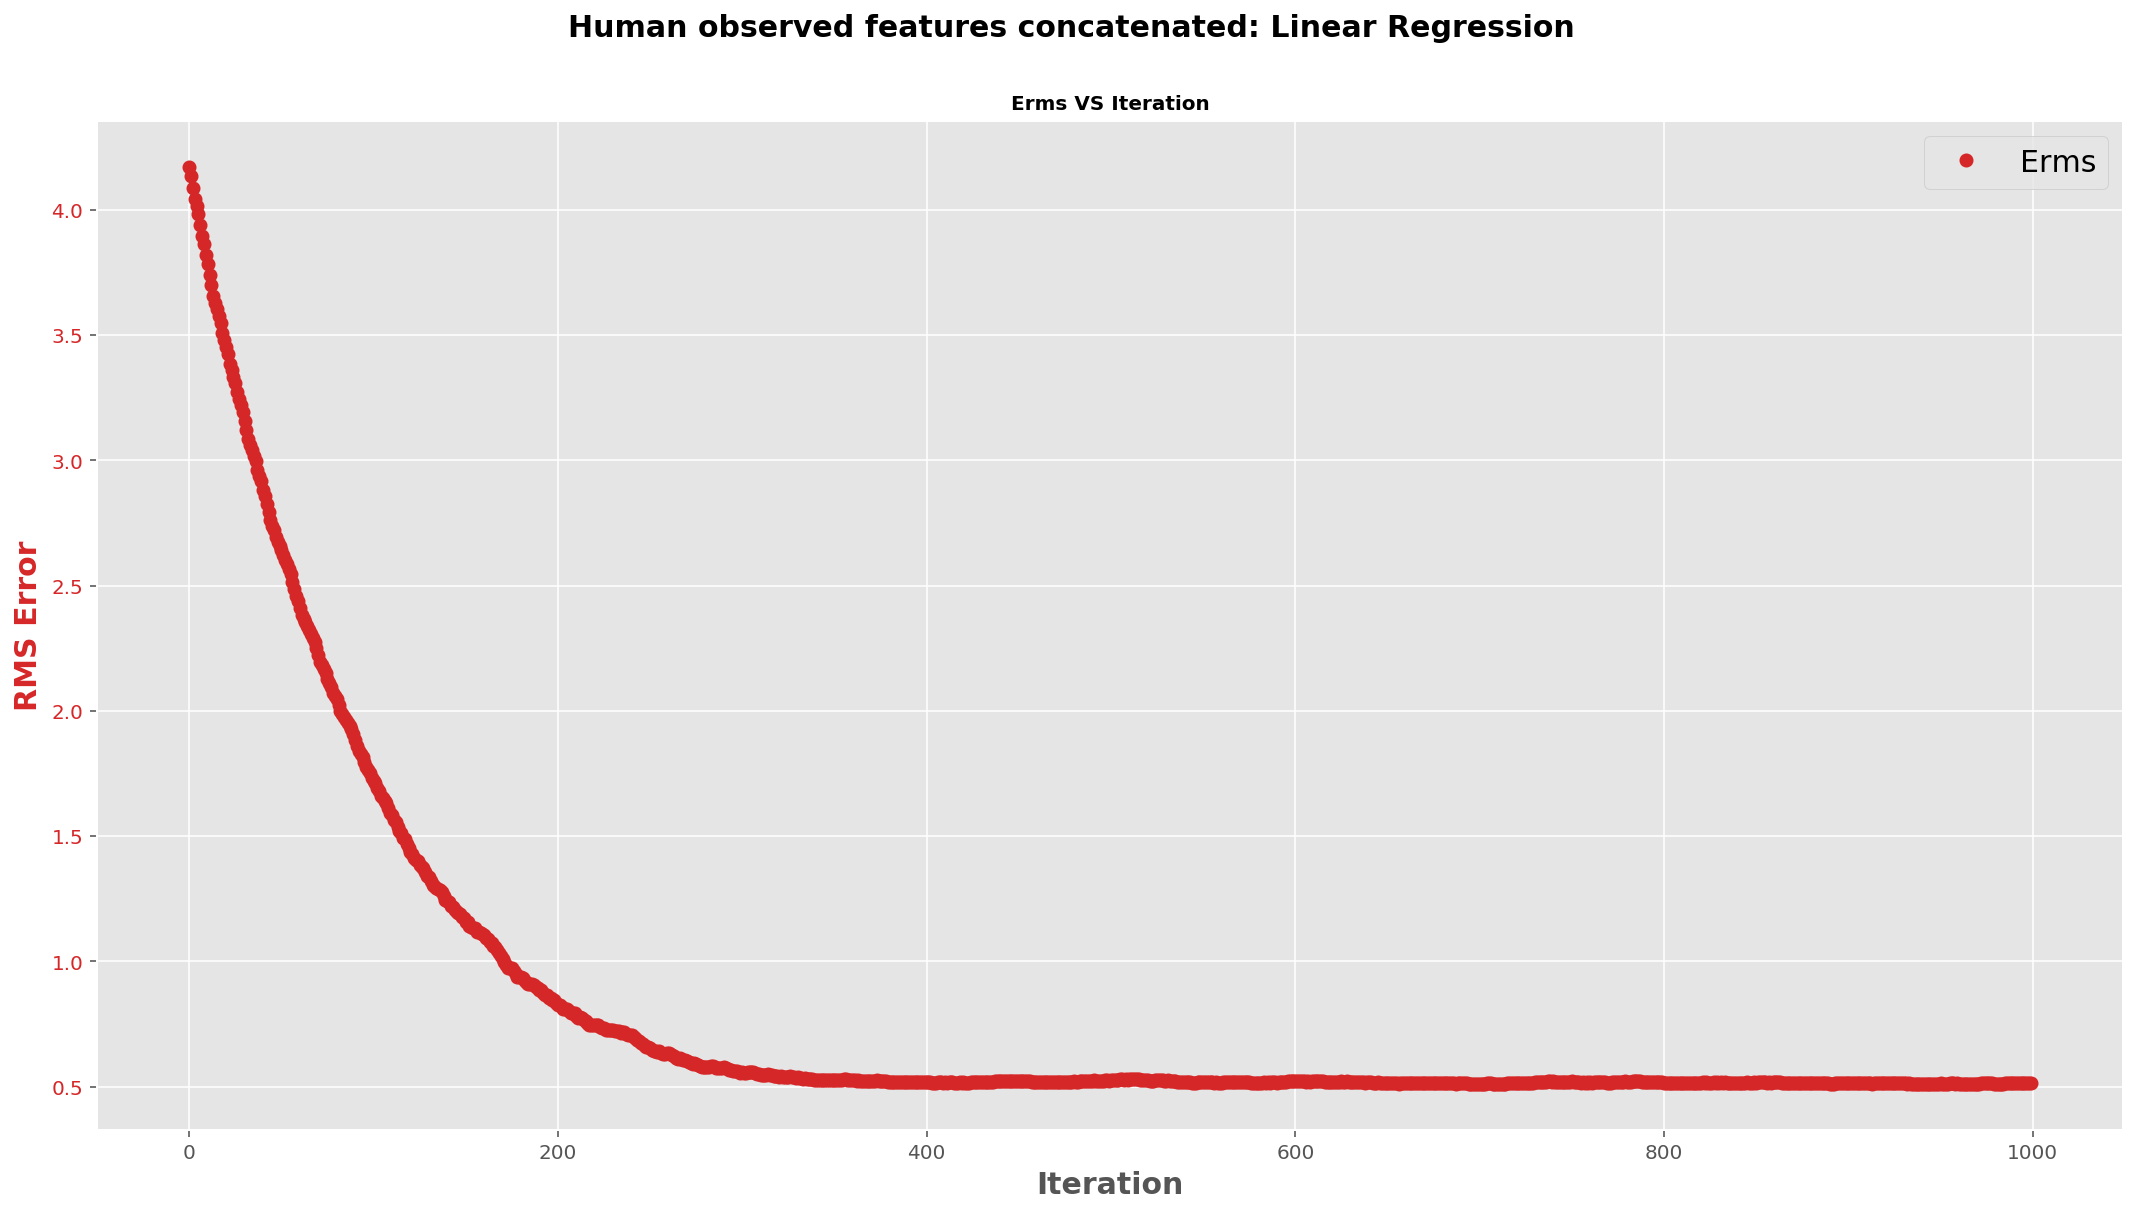

In [74]:
#plot and compute 
#Human observed Concatenated features
Hu_Conc_Lin = GradientDescent_Linear(TRAINING_PHI_conc, VAL_PHI_conc, TEST_PHI_conc, 
                        TrainingTarget_conc, ValTarget_conc, TestTarget_conc, 
                        Lambda = 0.1, LearningRate = 0.001 , Iteration = 1000 )


print('--------Human Observed Concatenated---------\n')
for key, value in Hu_Conc_Lin.items():
    print(key, value[-1])
    
Errplot(Hu_Conc_Lin['TestError'],
        title = "Human observed features concatenated: Linear Regression", figname = 'Linear_Conc')

--------Human Observed Subtracted---------

TrainingAccuracy 50.947867298578196
ValidationAccuracy 39.24050632911392
TestAccuracy 53.503184713375795
TrainingError 0.5032097986481235
ValidationError 0.5078804291193951
TestError 0.5012449596710995


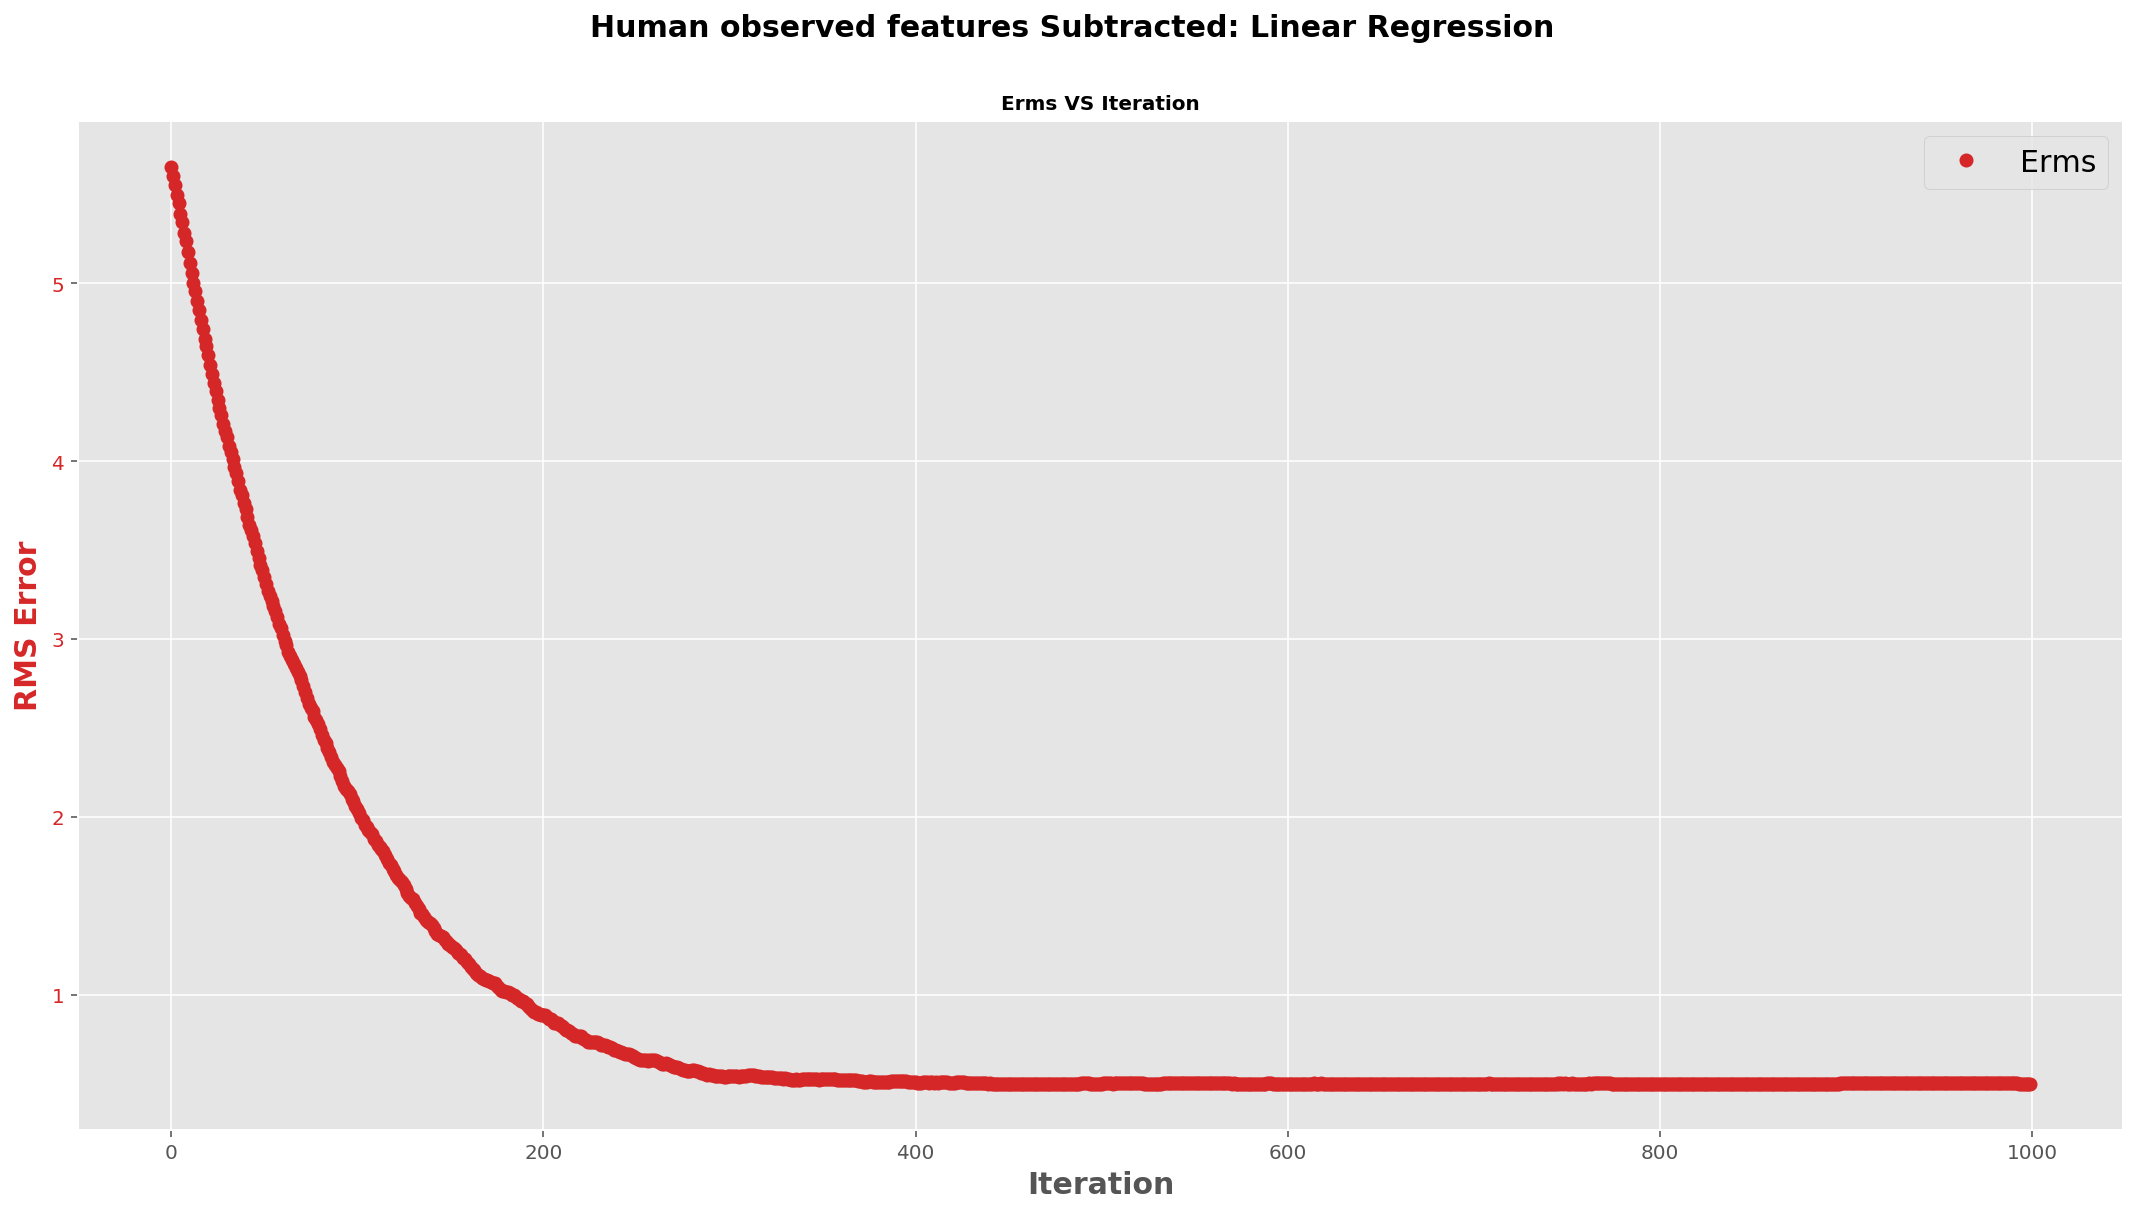

In [75]:
#Human observed Subtracted features
#plot and compute
Hu_Sub_Lin = GradientDescent_Linear(TRAINING_PHI_sub, VAL_PHI_sub, TEST_PHI_sub, 
                        TrainingTarget_sub, ValTarget_sub, TestTarget_sub,
                        Lambda = 0.1, LearningRate = 0.001, Iteration = 1000 )

print('--------Human Observed Subtracted---------\n')

for key, value in Hu_Sub_Lin.items():
    
    print(key, value[-1])
Errplot(Hu_Sub_Lin['TestError'],
        title = "Human observed features Subtracted: Linear Regression", figname = 'Linear_Sub')


# Model 2 : Logistic Regression

In [90]:
#Define sigmoid Function
def Sigmoid(y):
    S = 1.0/(1.0 + np.exp(-y))
    return S

# y = w.T*x 
def OutputValue(PhiMatrix, W_New):
    Op = np.dot(PhiMatrix, W_New)
    ##print ("Test Out Generated..")
    return Sigmoid(Op)

#define error function for logistic regression
def Error_logis(OutputValue, TargetValue):
    Error = (-TargetValue*np.log(OutputValue) - (1-TargetValue)*np.log(1-OutputValue)).sum()/len(TargetValue)
    return Error

#get Erms
def GetErms(OutputValue, TargetValue):
    return (str(math.sqrt(2*Error_logis(OutputValue, TargetValue)/len(OutputValue))))
 
#get accuracy %
def Accuracy(OutputValue, TargetValue):
    return str(((np.round(OutputValue) == TargetValue).sum().astype(float)/len(TargetValue))*100)

#plot accuracy and Erms vs iterations

def makeplot(Erms, Accuracy, title = None, figname = None ):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(title, fontsize=15, fontweight = 'bold', y = 1.05)
    ax1.grid(True)
    color = 'tab:red'
    ax1.set_xlabel('Iteration', fontweight = 'bold', fontsize = '15')
    ax1.set_ylabel('RMS Error',fontweight = 'bold', fontsize = '15', color=color)
    ax1.plot(range(len(Erms)), Erms, 'o', color=color, label = 'Erms')
    # ax1.set_ylim(0,)
    ax1.legend(fontsize = 15)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_title('Erms VS Iteration', fontweight = 'bold', fontsize = '10')
    
    ax2.grid(True)
    color = 'tab:blue'
    ax2.set_xlabel('Iteration', fontweight = 'bold', fontsize = '15')
    ax2.set_ylabel('Accuracy',fontweight = 'bold', fontsize = '15', color=color)  
    ax2.plot(range(len(Accuracy)), Accuracy, '*',  color=color, label = 'Accuracy')
    ax2.set_ylim(40, 100)
    ax2.legend(loc ='upper left', fontsize = 15)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_title('Accuracy VS Iteration', fontweight = 'bold', fontsize = '10')
    
    fig.tight_layout()
    %config InlineBackend.figure_format = 'retina'
    
    plt.savefig(figname + '.png')
    return plt.show()

# Gradient Descent for Logistic Regression

In [91]:
def GradientDescent_Logistic(Tr_Phi, Val_Phi, Test_Phi, Tr_Target, Val_Target, 
                           Test_Target, Lambda, LearningRate, Iteration):
    #initializing weight
    W_Now = np.array(np.dot(10, np.zeros(Tr_Phi.shape[1])))
    #W_Now = np.random.rand(Tr_Phi.shape[1], )

    Erms_Val   = []
    Erms_TR    = []
    Erms_Test  = []

    #Accuracies with each iteration
    Acc_TR = []
    Acc_Val = []
    Acc_Test = []
    for i in range(0, Iteration):  
    #     learningRate = 1/np.sqrt(10*(i+1)) # learning rate decreases with every iteration, # self adjusting 
    
        #Sigmoid             
        Y = Sigmoid(np.dot(Tr_Phi, W_Now))

        #gradient of error function for logistic regression
        Delta_E_D = np.dot( Tr_Phi.T, np.array(Y - Tr_Target))/Tr_Phi.shape[1]

        #adding regularizer term 
        Lambda_Delta_E_W  = np.dot(Lambda,W_Now)  # 
        Delta_E       = np.add(Delta_E_D, Lambda_Delta_E_W.T)    # eqn 10

        #updating the weight
        Delta_W       = -np.dot(LearningRate,Delta_E)
        W_T_Next      = W_Now + Delta_W  # new weight
        W_Now         = W_T_Next # updated weight

        #-----------------TrainingData Accuracy---------------------#
        TR_TEST_OUT   = OutputValue(Tr_Phi,W_Now) 
        E_TR          = GetErms(TR_TEST_OUT, Tr_Target)
        Erms_TR.append(E_TR)

        A_TR = Accuracy(np.round(TR_TEST_OUT),Tr_Target)
        Acc_TR.append(A_TR)

#         #-----------------ValidationData Accuracy---------------------#
        VAL_TEST_OUT  = OutputValue(Val_Phi,W_Now) 
        E_Val         = GetErms(VAL_TEST_OUT, Val_Target)
        Erms_Val.append(E_Val)


        A_Val = Accuracy(np.round(VAL_TEST_OUT),Val_Target)
        Acc_Val.append(A_Val)

        #-----------------TestingData Accuracy---------------------#
        TEST_OUT      = OutputValue(Test_Phi,W_Now) 
        E_Test        = GetErms(TEST_OUT,Test_Target)
        Erms_Test.append(E_Test)

        A_Test = Accuracy(np.round(TEST_OUT), Test_Target)
        Acc_Test.append(A_Test)
        
#     print('************Logistic Regression************\n')

    return {'TrainingAccuracy': Acc_TR, 'ValidationAccuracy':Acc_Val, 'TestAccuracy':Acc_Test,
            'TrainingError': Erms_TR, 'ValidationError': Erms_Val,'TestError': Erms_Test}

## Logistic Regression: Accuracy and Erms results and plot

In [96]:
# La = [0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05]
# #LR = [0.001, 0.005, 0.01, 0.05, 0.1]
# Er = []
# A = []
# for i in La:
#     Hu_Conc_Log = GradientDescent_Logistic(TRAINING_PHI_conc, VAL_PHI_conc, TEST_PHI_conc, 
#                         TrainingTarget_conc, ValTarget_conc, TestTarget_conc,
#                         Lambda = i, LearningRate = 0.001, Iteration = 60000 )
#     Er.append(Hu_Conc_Log['TestError'][-1])
#     A.append(Hu_Conc_Log['TestAccuracy'][-1])

# print(Er)
# print(A)
# df = pd.DataFrame({'La': La, 'Erms': Er, 'Acc': A})
# df.to_csv('Log_La_conc.txt', sep = ',')

['0.0669440789442578', '0.06864623515861763', '0.0705780603394197', '0.07382331121274631', '0.07636890793634227', '0.07837724354103509', '0.07998416722532481']
['90.44585987261146', '91.0828025477707', '91.0828025477707', '91.0828025477707', '91.0828025477707', '91.0828025477707', '90.44585987261146']


--------Human Observed Concatenated---------


TrainingAccuracy 85.22906793048973
ValidationAccuracy 84.81012658227847
TestAccuracy 87.26114649681529
TrainingError 0.03219465352448671
ValidationError 0.09111900287310538
TestError 0.0914015467892789


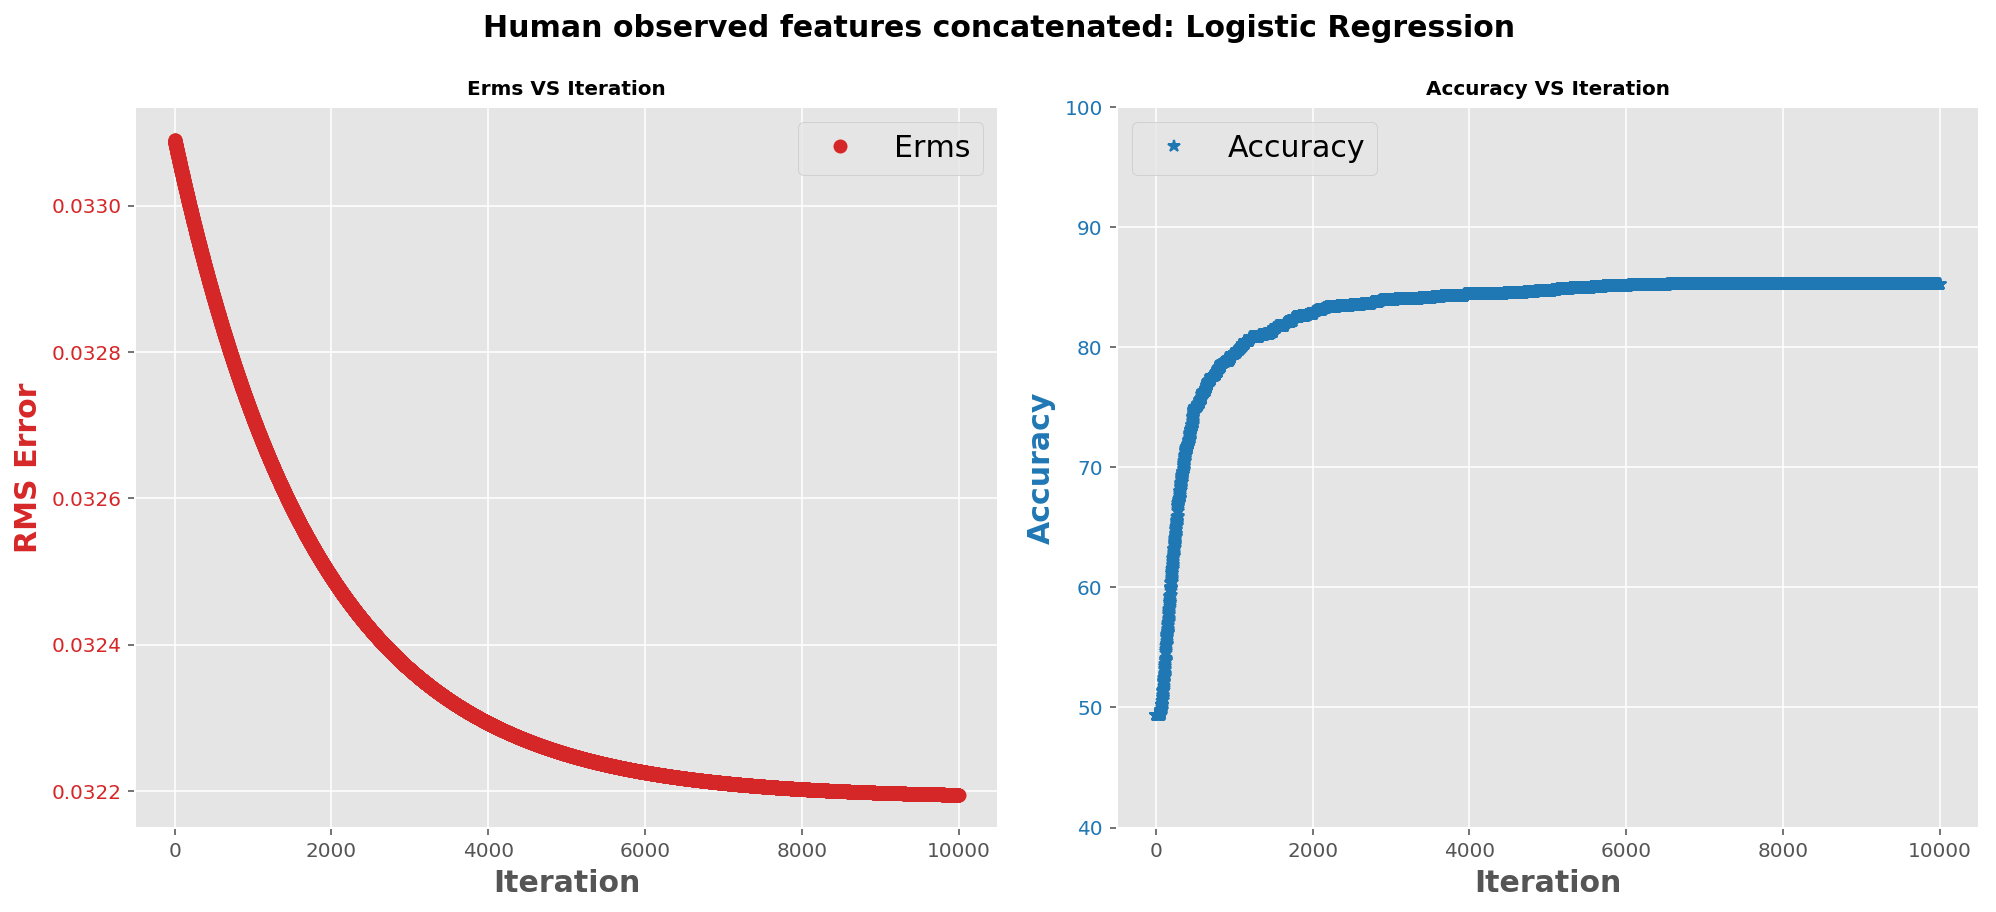

In [63]:
# features concatenated dataset: Accuracy and Erms
Hu_Conc_Log = GradientDescent_Logistic(TRAINING_PHI_conc, VAL_PHI_conc, TEST_PHI_conc, 
                        TrainingTarget_conc, ValTarget_conc, TestTarget_conc,
                        Lambda = 0.5, LearningRate = 0.001, Iteration = 10000 )

print('--------Human Observed Concatenated---------')
print('\n')
for key, value in Hu_Conc_Log.items():
    print(key, value[-1])
    
makeplot(Hu_Conc_Log['TrainingError'],Hu_Conc_Log['TrainingAccuracy'],
        title = "Human observed features concatenated: Logistic Regression", figname = 'Logistic_Conc')

--------Human Observed Subtracted---------


TrainingAccuracy 75.9083728278041
ValidationAccuracy 65.82278481012658
TestAccuracy 78.343949044586
TrainingError 0.03206250161956189
ValidationError 0.09189534696034263
TestError 0.09060768412820912


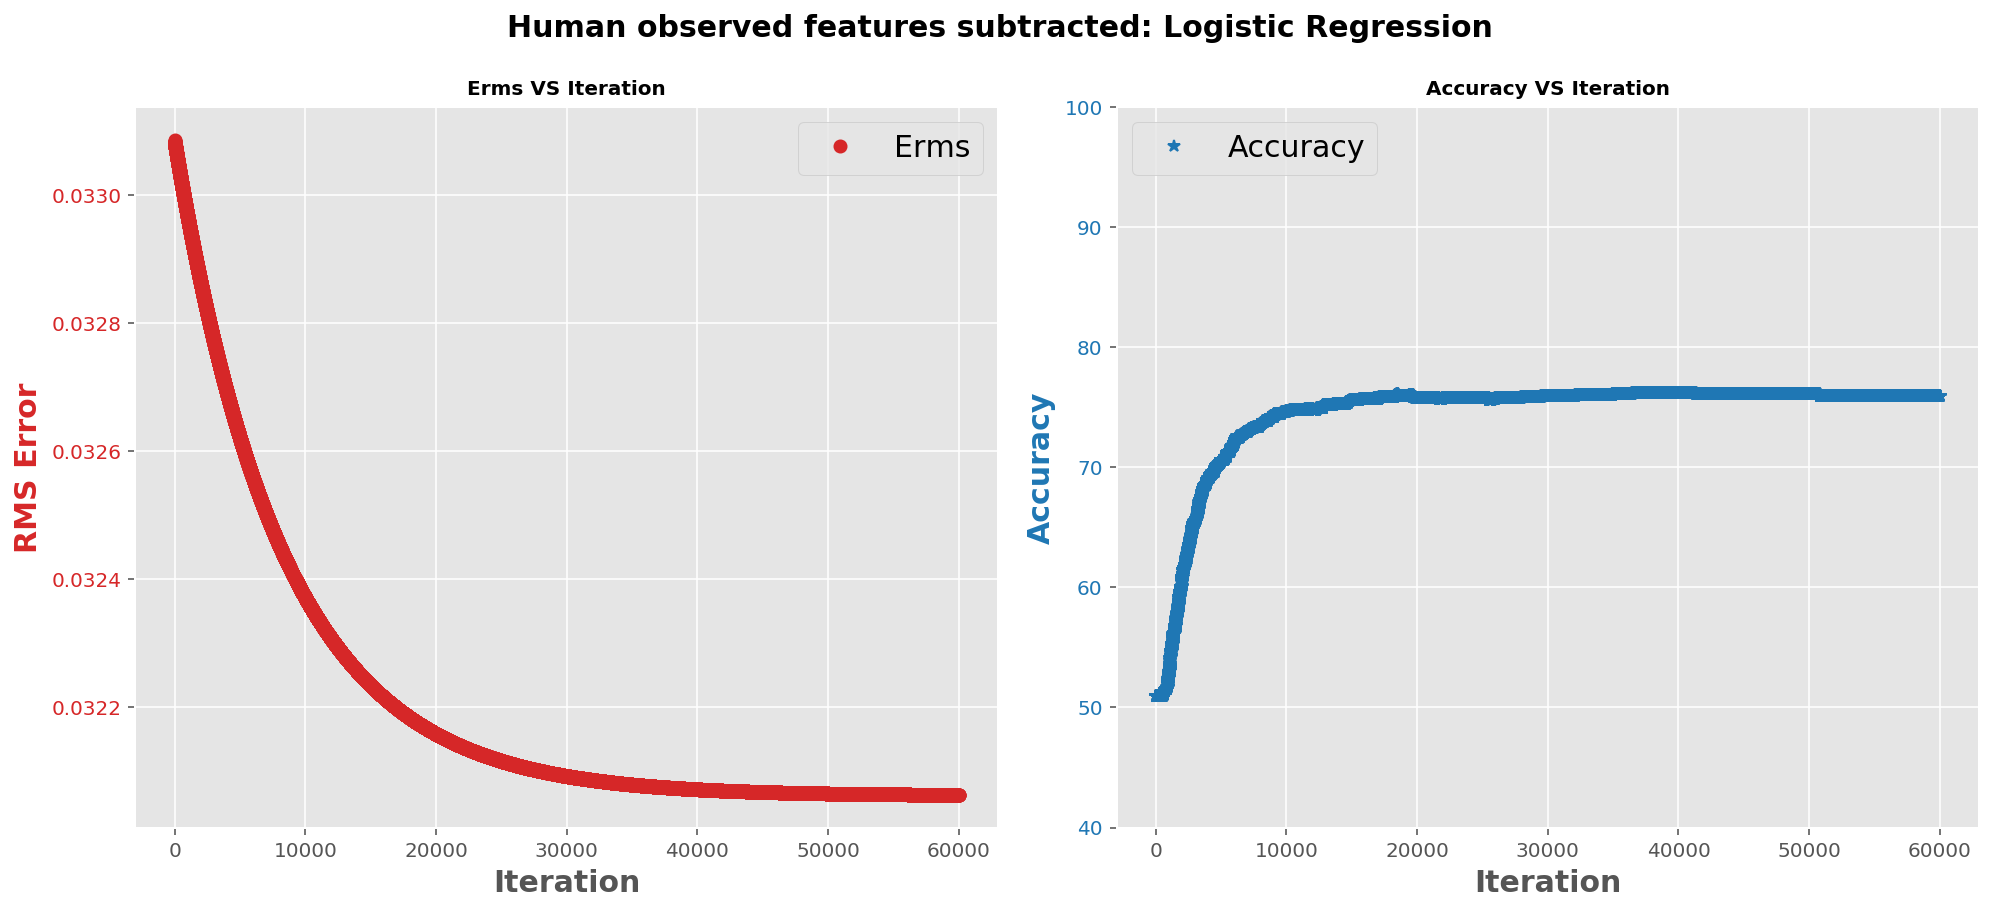

In [66]:
#features subtracted dataset
Hu_Sub_Log  = GradientDescent_Logistic(TRAINING_PHI_sub, VAL_PHI_sub, TEST_PHI_sub, 
                        TrainingTarget_sub, ValTarget_sub, TestTarget_sub,
                        Lambda = 0.1, LearningRate = 0.001, Iteration = 60000 )
    
print('--------Human Observed Subtracted---------')
print('\n')
for key, value in Hu_Sub_Log.items():
    
    print(key, value[-1])

makeplot(Hu_Sub_Log['TrainingError'],Hu_Sub_Log['TrainingAccuracy'],
        title = "Human observed features subtracted: Logistic Regression", figname = 'Logistic_Sub')


# Logistic Regression without using Basis Functions

--------Human Observed Subtracted---------


TrainingAccuracy 98.9375
ValidationAccuracy 98.8988988988989
TestAccuracy 98.2982982982983
TrainingError 0.004388705865717469
ValidationError 0.013218764492036567
TestError 0.01394024789351771


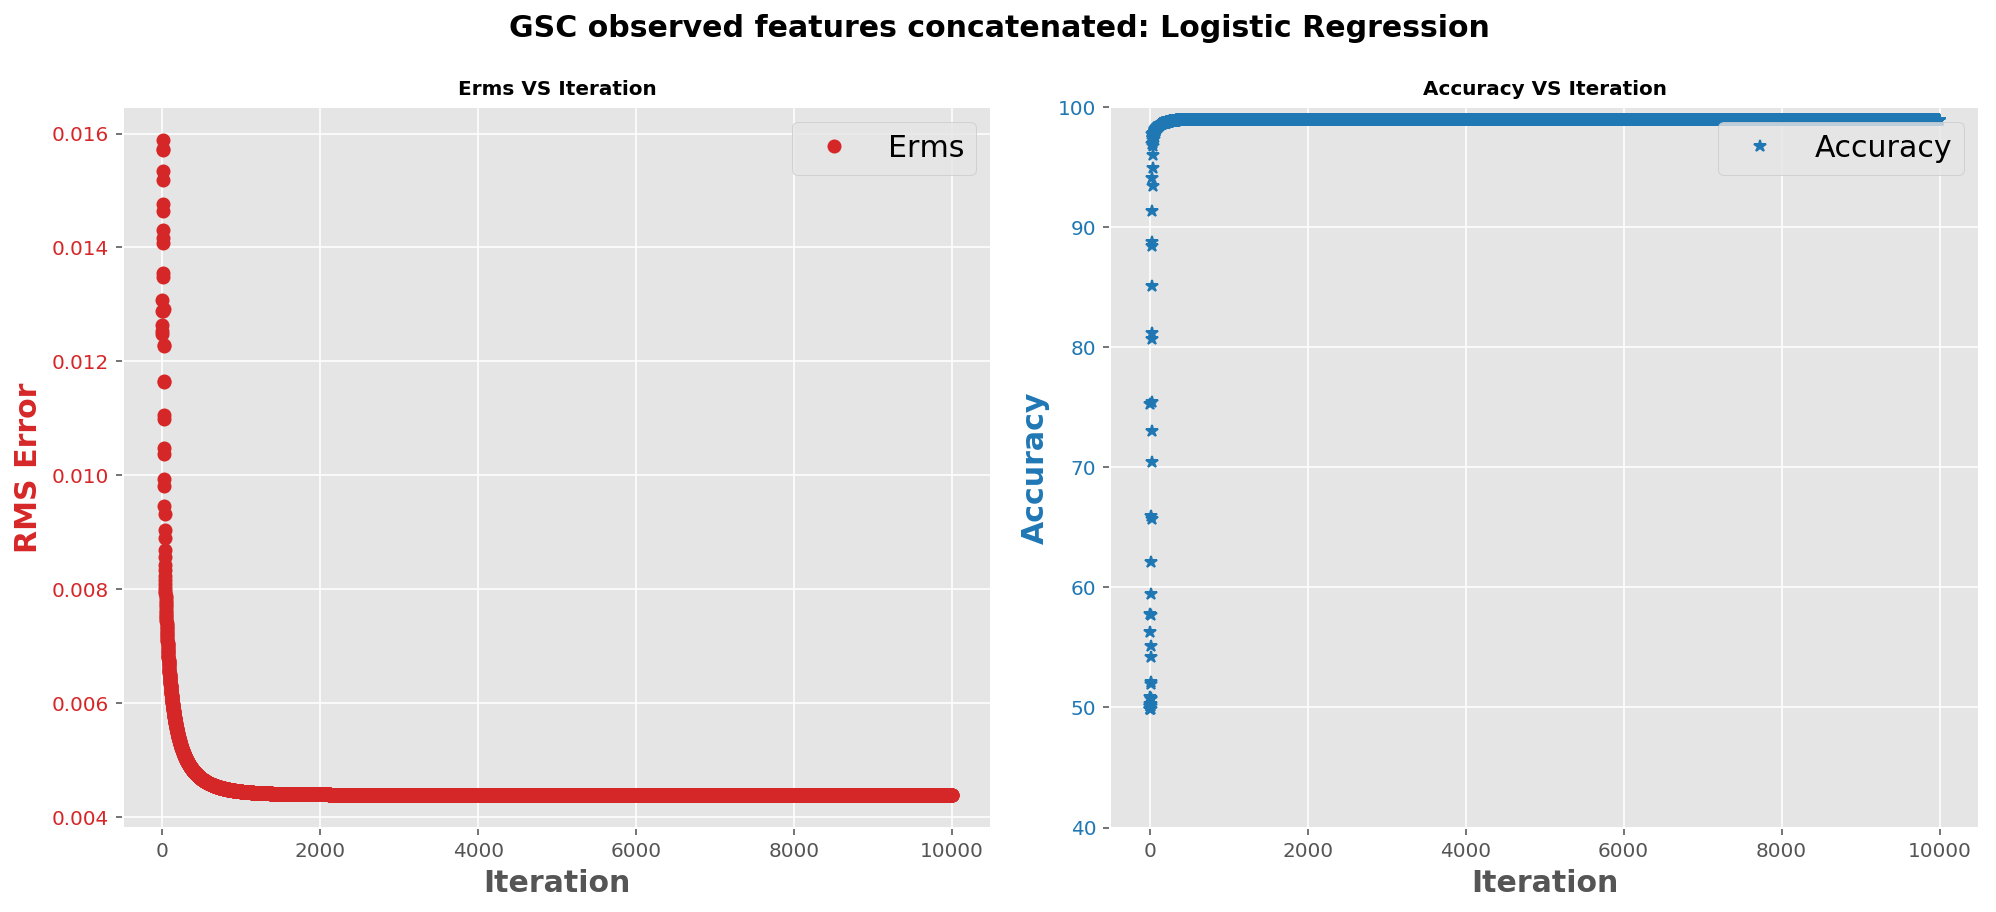

In [185]:
# #features subtracted dataset
# Hu_conc_Log  = GradientDescent_Logistic(TrainingData_conc, ValData_conc,  TestData_conc, 
#                                        TrainingTarget_conc, ValTarget_conc, TestTarget_conc, 
#                                        Lambda = 0.1, LearningRate = 0.01, Iteration = 10000)
    
# print('--------Human Observed Subtracted---------')
# print('\n')
# for key, value in Hu_conc_Log.items():
    
#     print(key, value[-1])

# makeplot(Hu_conc_Log['TrainingError'],Hu_conc_Log['TrainingAccuracy'],
#         title = "GSC observed features concatenated: Logistic Regression", figname = 'Logistic_Sub')

--------Human Observed Subtracted---------


TrainingAccuracy 91.5875
ValidationAccuracy 87.58758758758759
TestAccuracy 89.1891891891892
TrainingError 0.007902274228789117
ValidationError 0.024626251085572492
TestError 0.02376115049127662


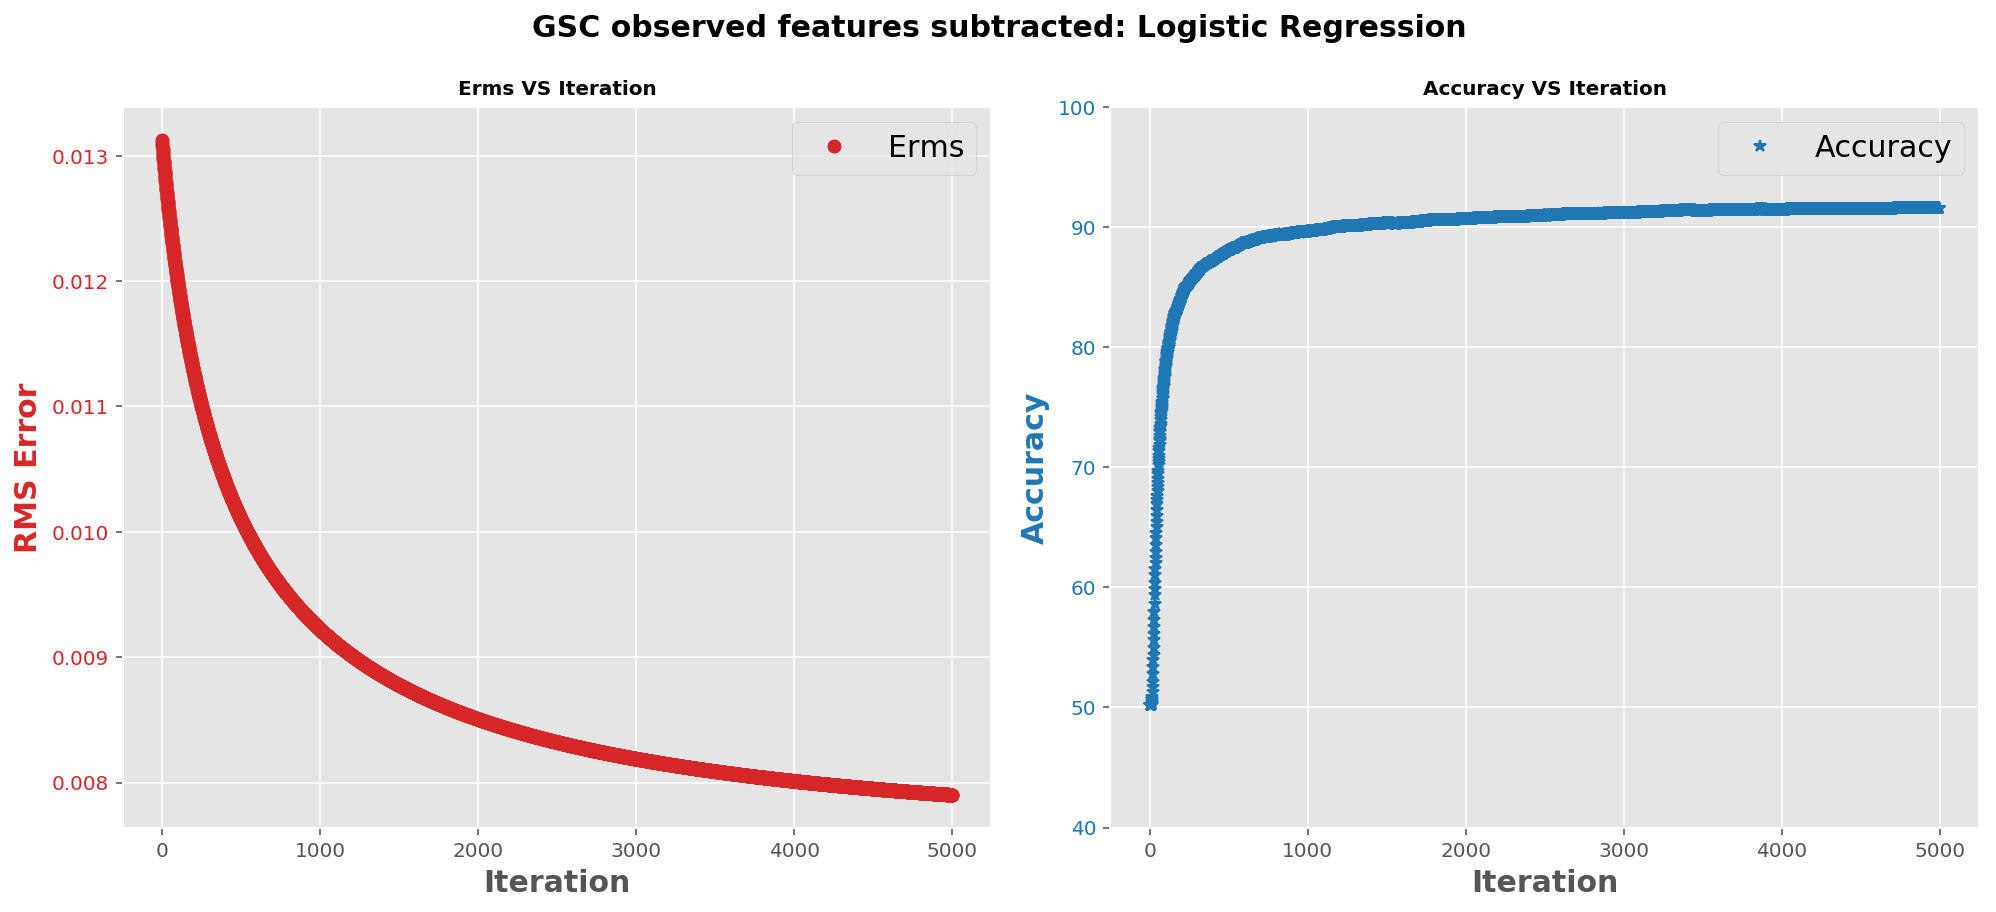

In [184]:
# #features subtracted dataset
# Hu_Sub_Log  = GradientDescent_Logistic(TrainingData_sub, ValData_sub,  TestData_sub, 
#                                        TrainingTarget_sub, ValTarget_sub, TestTarget_sub, 
#                                        Lambda = 0.1, LearningRate = 0.01, Iteration = 10000)
    
# print('--------Human Observed Subtracted---------')
# print('\n')
# for key, value in Hu_Sub_Log.items():
    
#     print(key, value[-1])

# makeplot(Hu_Sub_Log['TrainingError'],Hu_Sub_Log['TrainingAccuracy'],
#         title = "GSC observed features subtracted: Logistic Regression", figname = 'Logistic_Sub')

# Model 3 Neural Network implementation using TensorFlow

In [98]:
import tensorflow as tf
from tqdm import tqdm_notebook
from keras.utils import np_utils

/Users/TenzinNorden/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/TenzinNorden/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


###  GSC Dataset: concatenated and subtracted

In [99]:
# set data for Neural Network: 90% for Training and 10% for Testing

#set 90% of data as Training
t =int(0.9*len(feature_conc))

#get traning data for concatenated
Train_Data_conc = feature_conc[:t]
Test_Data_conc = feature_conc[t+1:]

#get Training Target
Train_Target_conc = np.array([[i] for i in np.array(Target_conc[:t])])
Test_Target_conc = np.array([[i] for i in np.array(Target_conc[t+1:])])

#Feature subtracted Training and Target

#get traning data for concatenated
Train_Data_sub = feature_sub[:t]
Test_Data_sub = feature_sub[t+1:]

#get Training Target
Train_Target_sub = np.array([[i] for i in np.array(Target_sub[:t])])
Test_Target_sub = np.array([[i] for i in np.array(Target_sub[t+1:])])

print(Train_Data_conc.shape)
print(Test_Data_conc.shape)
print(Train_Target_conc.shape)
print(Test_Target_conc.shape)

print(Train_Data_sub.shape)
print(Test_Data_sub.shape)
print(Train_Target_sub.shape)
print(Test_Target_sub.shape)

(1423, 18)
(158, 18)
(1423, 1)
(158, 1)
(1423, 9)
(158, 9)
(1423, 1)
(158, 1)


In [100]:
def RunTenFlw(Train_Data, Train_Target, Test_Data, NUM_OF_EPOCHS, BATCH_SIZE ):

    #NUM_OF_EPOCHS = 5000  #number of forward and backward propagation of the full training data
    #BATCH_SIZE = 100  #number of training data set in one forward and backward propagation 

    training_accuracy = []

# A tensorflow session is set to run the tensorflow model graph above. 
    with tf.Session() as sess:  
    
    # Set Global Variables ?
    #Initialize all the variables (weights) at once. 
        tf.global_variables_initializer().run()
    
        for epoch in tqdm_notebook(range(NUM_OF_EPOCHS)):
        
        #Shuffle the Training Dataset at each epoch
            p = np.random.permutation(range(len(Train_Data)))
            processedTrainingData  = Train_Data[p]
            processedTraininglabel = Train_Target[p]
        
        # Start batch training  
            for start in range(0, len(processedTrainingData), BATCH_SIZE):
                end = start + BATCH_SIZE
                sess.run(training, feed_dict={inputTensor: processedTrainingData[start:end], 
                                          outputTensor: processedTraininglabel[start:end]})
        # Training accuracy for an epoch 
            training_accuracy.append(np.mean((processedTraininglabel) == 
                                            sess.run(prediction, feed_dict={inputTensor: processedTrainingData, 
                                                                            outputTensor: processedTraininglabel})))
    # Testing : processedtesting data as input
        predictedTestTarget = sess.run(prediction, feed_dict={inputTensor: Test_Data})
   # erroroutput = sess.run(error_function, feed_dict={inputTensor:processedTrainingData,
#                                                      outputTensor: processedTrainingLabel})
    return training_accuracy, predictedTestTarget

In [121]:
# Defining Placeholder
inputTensor  = tf.placeholder(tf.float32, [None, 18]) #for 10bit input vector activations
outputTensor = tf.placeholder(tf.float32, [None, 1])  #a bucket for 4 classes of output

#Neural Network model for 2 hidden layer is defined 
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape,stddev=0.01))

#two layer neural network model
NUM_HIDDEN_NEURONS_LAYER_1 = 100
NUM_HIDDEN_NEURONS_LAYER_2 = 100

# hyperparameter. change from 0.1 to 1 for this project
LEARNING_RATE = 1

# Initializing the weights to Normal Distribution   (random values)


# Initializing the input to hidden layer weights
input_hidden_weights1  = init_weights([18, NUM_HIDDEN_NEURONS_LAYER_1])    


#Initializing the input to hidden layer 2 weights
input_hidden_weights2  = init_weights([NUM_HIDDEN_NEURONS_LAYER_1, NUM_HIDDEN_NEURONS_LAYER_2])


# Initializing the hidden to output layer 2 weights
hidden_output_weights2 = init_weights([NUM_HIDDEN_NEURONS_LAYER_2, 1])


# Computing values at the hidden layer 1
#Relu is applied on te sum of the product of the inputtensor and input_hidden_weights;  
hidden_layer1 = tf.nn.relu(tf.matmul(inputTensor, input_hidden_weights1))  

#computing values at 2nd hiddend layer
hidden_layer2 = tf.nn.relu(tf.matmul(hidden_layer1, input_hidden_weights2))



# Computing values at the output layer
#output of hidden layer is fed as input for the output layer and it is multiplied with weights
output_layer = tf.matmul(hidden_layer2, hidden_output_weights2)


# Defining Error Function # cost function. we need to minimize it  
#sigmoid activation function is used
#cross_entropy error function as used for this classifier problem which makes backpropagation math easier
error_function = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=output_layer, labels=outputTensor))

# Defining Learning Algorithm and Training Parameters
# gradientdescent optimizer is used to minimize the error function. 
#set learning rate hyper parameter. determines the step of the gradient descent. 
training = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(error_function)  #optimizer, minimizing error

# Prediction Function # prediction will be the largest output
prediction = tf.round(tf.sigmoid(output_layer))

#prediction = output_layer

In [122]:
#run tensorflow
H_Tr_Acc_conc, H_Predic_conc = RunTenFlw(Train_Data_conc, Train_Target_conc, Test_Data_conc, 
                                         BATCH_SIZE=100, NUM_OF_EPOCHS= 5000)

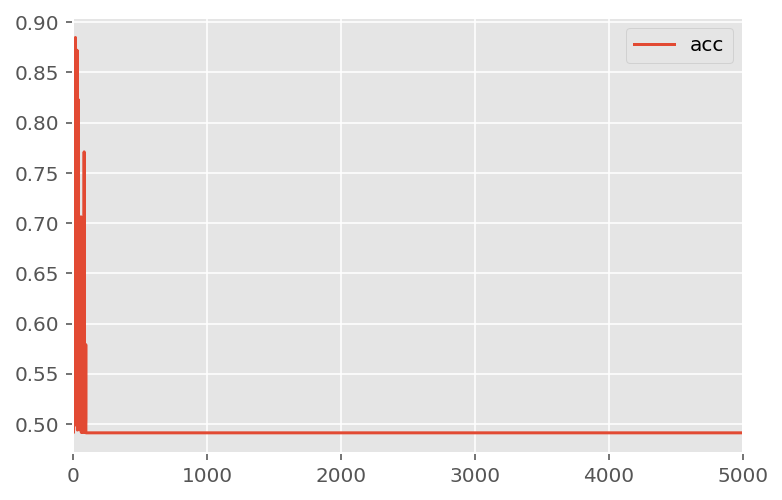

----Human Observed Feature concatenation Dataset-------
-------------Testing Accuracy----------------
58.22784810126582


In [123]:
# pandas dataframe. plotting traning accuracy for every epochs. 
df = pd.DataFrame()
df['acc'] = H_Tr_Acc_conc
df.plot(grid=True)
plt.show()


#print accuracy of model on Testing dataset
print('----Human Observed Feature concatenation Dataset-------')
print('-------------Testing Accuracy----------------')
print(Accuracy(H_Predic_conc, Test_Target_conc))

In [142]:
# Defining Placeholder
inputTensor  = tf.placeholder(tf.float32, [None, 9]) #for 10bit input vector activations
outputTensor = tf.placeholder(tf.float32, [None, 1])  #a bucket for 4 classes of output

#Neural Network model for 2 hidden layer is defined 
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape,stddev=0.01))

#two layer neural network model
NUM_HIDDEN_NEURONS_LAYER_1 = 100
NUM_HIDDEN_NEURONS_LAYER_2 = 100

# hyperparameter. change from 0.1 to 1 for this project
LEARNING_RATE = 0.1

# Initializing the weights to Normal Distribution   (random values)


# Initializing the input to hidden layer weights
input_hidden_weights1  = init_weights([9, NUM_HIDDEN_NEURONS_LAYER_1])    


#Initializing the input to hidden layer 2 weights
input_hidden_weights2  = init_weights([NUM_HIDDEN_NEURONS_LAYER_1, NUM_HIDDEN_NEURONS_LAYER_2])


# Initializing the hidden to output layer 2 weights
hidden_output_weights2 = init_weights([NUM_HIDDEN_NEURONS_LAYER_2, 1])


# Computing values at the hidden layer 1
#Relu is applied on te sum of the product of the inputtensor and input_hidden_weights;  
hidden_layer1 = tf.nn.relu(tf.matmul(inputTensor, input_hidden_weights1))  

#computing values at 2nd hiddend layer
hidden_layer2 = tf.nn.relu(tf.matmul(hidden_layer1, input_hidden_weights2))



# Computing values at the output layer
#output of hidden layer is fed as input for the output layer and it is multiplied with weights
output_layer = tf.matmul(hidden_layer2, hidden_output_weights2)


# Defining Error Function # cost function. we need to minimize it  
#sigmoid activation function is used
#cross_entropy error function as used for this classifier problem which makes backpropagation math easier
error_function = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=output_layer, labels=outputTensor))

# Defining Learning Algorithm and Training Parameters
# gradientdescent optimizer is used to minimize the error function. 
#set learning rate hyper parameter. determines the step of the gradient descent. 
training = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(error_function)  #optimizer, minimizing error

# Prediction Function # prediction will be the largest output
prediction = tf.round(tf.sigmoid(output_layer))

#prediction = output_layer

In [143]:
#run tensor flow
H_Tr_Acc_sub, H_Prediction_sub = RunTenFlw(Train_Data_sub, Train_Target_sub, 
                                         Test_Data_sub, BATCH_SIZE=100, NUM_OF_EPOCHS= 5000)

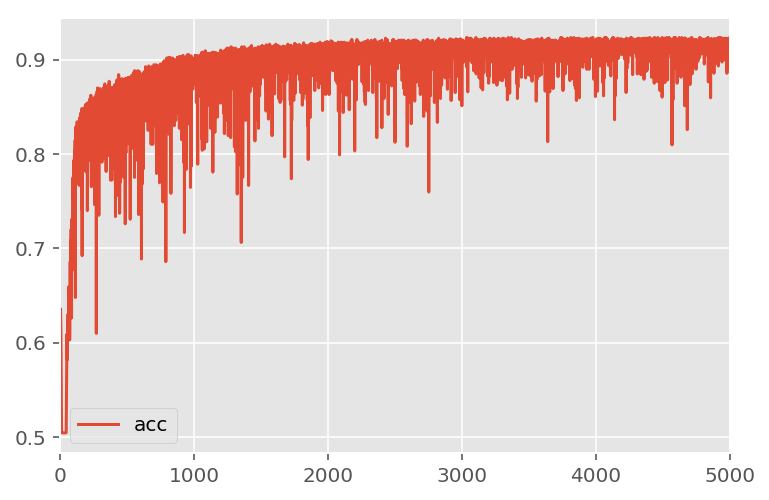

----Human Observed Feature concatenation Dataset-------
-------------Testing Accuracy----------------


'82.27848101265823'

In [144]:
# pandas dataframe. plotting traning accuracy for every epochs. 
df = pd.DataFrame()
df['acc'] = H_Tr_Acc_sub
df.plot(grid=True)
plt.show()

#print accuracy of model on Testing dataset
print('----Human Observed Feature concatenation Dataset-------')
print('-------------Testing Accuracy----------------')
Accuracy(H_Prediction_sub, Test_Target_sub)